<a href="https://colab.research.google.com/github/styxx216/ML/blob/main/CommonLit_Deberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 9.3MB/s 
     |████████████████████████████████| 901kB 43.4MB/s 
     |████████████████████████████████| 3.3MB 50.8MB/s 


In [ ]:
from transformers import DebertaTokenizer, DebertaModel

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import transformers as ppb
from sklearn.metrics import mean_squared_error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
train_path='/content/drive/MyDrive/datasets/CommonLit/train.csv'
test_path='/content/drive/MyDrive/datasets/CommonLit/test.csv'
submission_path='/content/drive/MyDrive/datasets/CommonLit/sample_submission.csv'

In [ ]:
data=pd.read_csv(train_path)
data

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


# Data

<a list of 100 Patch objects>

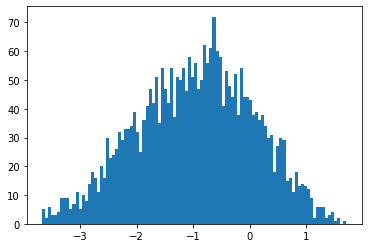

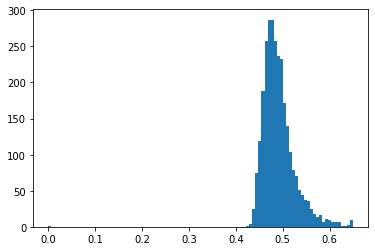

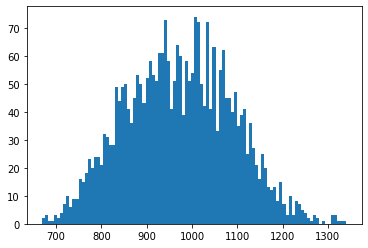

In [ ]:
plt.figure()
plt.hist(data['target'],bins=100)[2]
plt.figure()
plt.hist(data['standard_error'],bins=100)[2]
plt.figure()
plt.hist(list(map(len, data['excerpt'])),bins=100)[2]

# Новый раздел

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
deberta_model = DebertaModel.from_pretrained('microsoft/deberta-base')

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'config', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [ ]:
class TextDataset(Dataset):
  def __init__(self,path,max_len=250):
    self.max_len=max_len
    data=pd.read_csv(path)
    self.targets=list(data['target'])
    text=list(data['excerpt'])
    self.text = list(map(lambda x: x.replace('\n', ''),text))
    self.tokenized = list(map(lambda x:tokenizer.encode_plus(
        x, 
        max_length=max_len, 
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True
      ),text))

  def __len__(self):
    return len(self.targets)
  def __getitem__(self,idx): 
    tok=self.tokenized[idx]

    curr_sent = {}
    padding_length = self.max_len - len(tok['input_ids'])
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + \
        ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + \
        ([0] * padding_length)
    return torch.tensor(curr_sent['input_ids'],device=device),\
        torch.tensor(curr_sent['token_type_ids'],device=device),\
        torch.tensor(curr_sent['attention_mask'],device=device),\
        torch.tensor(self.targets[idx],device=device)


In [ ]:
ds=TextDataset(train_path)

In [ ]:
ds[0]

(tensor([    1,  1779,     5,   664,    82,  1835,     7,     5,  1011,  4294,
             6,    24,  2633,    10, 27265,  1714,  2772,     4,  2978,     9,
            41,  6291,  1310,     6,    24,    21,    10,  2608,  5252,     4,
         50118,   133,  1929,    21,  2913,    19,  1958,    12,  9830, 20790,
             6,    45,  4976,    15, 17359,     6,    53, 11122, 18331,    81,
         24271,     8,  9910,  6368,     6,   101,    10,   588,  1958,   882,
             4,    20,  3617, 38325,     8,   655,   571, 18656,    14,    56,
         14633,     5,   929,     6,    58, 39143,    19, 15039,     8, 22246,
         11538,    19, 13145, 21811,     9, 13178,     6,   101,  1958,     4,
          1578, 11720,  8402,    56,    57, 14998, 38073,    15,   106,     6,
             8, 19053,   154, 16155, 41591, 20846, 10601,    31,     5,  9836,
             4, 50118,  3750,   349,   253,     9,     5,   929,     6,    15,
             5,  2204,     6, 10601,    10,  2721,  

In [ ]:
batch_size=8
validation_split = 0.1
test_set,train_set=torch.utils.data.random_split(ds, [int(len(ds)*validation_split),len(ds)-int(len(ds)*validation_split)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [ ]:
class DeBerta_CommonLit(nn.Module):
  def __init__(self,deberta='microsoft/deberta-base'):
    super(DeBerta_CommonLit,self).__init__()
    self.DEBERTA=DebertaModel.from_pretrained(deberta)
    self.norm=nn.LayerNorm(768)
    self.attention=AttentionHead(768,768*5,1)
    self.dropout = nn.Dropout(0.1)
    self.linear_1=nn.Linear(768,1)
  def forward(self,x,token_type,mask):
    out=self.DEBERTA(input_ids=x,attention_mask=mask,token_type_ids=token_type)
    out=out.last_hidden_state
    out=self.attention(out)
    #out=self.norm(out)
    out=self.dropout(out)
    out=self.linear_1(out)
    return out

In [ ]:
def loss_fn(output,target):
   return torch.sqrt(nn.MSELoss()(output,target))
lr=1e-5/5
model=DeBerta_CommonLit()
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'config', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.DEBERTA.requires_grad_=False

In [ ]:
def test_model(model,testloader):
  res=0
  with torch.no_grad():
    model.eval()
    for data,mask,token_type, target in testloader:
      net_out = model(data,mask,token_type)
      target=target.reshape(len(target),1)
      loss = loss_fn(net_out, target)
      print(loss)
      res=res+loss             
  res=res/len(testloader)
  return res

In [ ]:
epochs=5
test_losses=[]
train_losses=[]
for epoch in range(epochs):
  epoch_train_loss=0
  epoch_test_loss=0
  for  batch_idx, (data,mask,token_type, target) in enumerate(train_loader):
    optimizer.zero_grad()
    net_out = model(data,mask,token_type)
    target=target.reshape(len(target),1)
    loss = loss_fn(net_out, target)  
    loss.backward()
    optimizer.step()
    
    epoch_train_loss=epoch_train_loss+loss
  epoch_train_loss=epoch_train_loss/len(train_loader)  
  test_losses.append(test_model(model,test_loader))
  train_losses.append(epoch_train_loss)

    

tensor(0.1257, device='cuda:0')
tensor(0.7138, device='cuda:0')
tensor(0.2671, device='cuda:0')
tensor(0.2402, device='cuda:0')
tensor(0.4962, device='cuda:0')
tensor(0.2317, device='cuda:0')
tensor(0.3035, device='cuda:0')
tensor(0.1712, device='cuda:0')
tensor(1.4378, device='cuda:0')
tensor(0.1934, device='cuda:0')
tensor(0.6607, device='cuda:0')
tensor(0.1886, device='cuda:0')
tensor(0.1028, device='cuda:0')
tensor(0.1391, device='cuda:0')
tensor(0.0217, device='cuda:0')
tensor(0.0936, device='cuda:0')
tensor(0.1661, device='cuda:0')
tensor(0.4604, device='cuda:0')
tensor(0.7092, device='cuda:0')
tensor(0.4303, device='cuda:0')
tensor(0.8111, device='cuda:0')
tensor(0.2526, device='cuda:0')
tensor(0.3311, device='cuda:0')
tensor(0.0360, device='cuda:0')
tensor(0.1214, device='cuda:0')
tensor(0.5216, device='cuda:0')
tensor(0.1404, device='cuda:0')
tensor(1.0210, device='cuda:0')
tensor(0.6277, device='cuda:0')
tensor(1.2010, device='cuda:0')
tensor(0.3711, device='cuda:0')
tensor(0

In [ ]:
train_losses

[tensor(0.7322, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5137, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4485, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3798, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3175, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
test_losses

[tensor(0.4434, device='cuda:0'),
 tensor(0.4111, device='cuda:0'),
 tensor(0.4089, device='cuda:0'),
 tensor(0.3977, device='cuda:0'),
 tensor(0.4082, device='cuda:0')]

In [ ]:
model.DEBERTA.requires_grad_=True
optimizer = torch.optim.Adam(model.parameters(), lr=lr/20)

In [ ]:
epochs=5

for epoch in range(epochs):
  epoch_train_loss=0
  epoch_test_loss=0
  for  batch_idx, (data,mask,token_type, target) in enumerate(train_loader):
    optimizer.zero_grad()
    net_out = model(data,mask,token_type)
    target=target.reshape(len(target),1)
    loss = loss_fn(net_out, target)  
    loss.backward()
    optimizer.step()
    
    epoch_train_loss=epoch_train_loss+loss
  epoch_train_loss=epoch_train_loss/len(train_loader)  
  test_losses.append(test_model(model,test_loader))
  train_losses.append(epoch_train_loss)
    

tensor(0.3489, device='cuda:0')
tensor(0.1303, device='cuda:0')
tensor(0.8087, device='cuda:0')
tensor(0.0820, device='cuda:0')
tensor(0.2464, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(0.7258, device='cuda:0')
tensor(0.3187, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(0.3416, device='cuda:0')
tensor(0.4885, device='cuda:0')
tensor(0.1230, device='cuda:0')
tensor(0.3749, device='cuda:0')
tensor(0.5615, device='cuda:0')
tensor(0.3967, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(0.6064, device='cuda:0')
tensor(0.0105, device='cuda:0')
tensor(0.1377, device='cuda:0')
tensor(0.5009, device='cuda:0')
tensor(0.5512, device='cuda:0')
tensor(0.3137, device='cuda:0')
tensor(0.7438, device='cuda:0')
tensor(0.2203, device='cuda:0')
tensor(0.0289, device='cuda:0')
tensor(0.0045, device='cuda:0')
tensor(0.2004, device='cuda:0')
tensor(0.6899, device='cuda:0')
tensor(1.1099, device='cuda:0')
tensor(0.5224, device='cuda:0')
tensor(0.3661, device='cuda:0')
tensor(0